### Self Implementation Decision Tree Classifier for Large Dataset (2010, 2014, 2018)

In [143]:
#Reference: https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/ 

#Importing dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#### Decision Tree Classification Model from scratch

In [144]:
#Node Class
#Each node holds feature index, threshold, left and right output, and info gain value
class Node():
    def __init__(self, featureIndex=None, threshold=None, left=None, right=None, infoGain=None, value=None):
        #for decision node
        self.featureIndex = featureIndex
        self.threshold = threshold
        self.left = left
        self.right = right
        self.infoGain = infoGain
        
        #for leaf node
        self.value = value

In [145]:
#Tree Class
#Include functions that help configure and build a decision tree
class DecisionTreeClassifier():

    #initializing the tree
    def __init__(self,minSamplesSplit,maxDepth): 
        self.root = None
        self.minSamplesSplit = minSamplesSplit
        self.maxDepth = maxDepth
    
    #predict only one data point
    def onePrediction(self,x,tree):        
        if tree.value != None: 

            return tree.value
        featureVal = x[tree.featureIndex]

        if featureVal <= tree.threshold:

            return self.onePrediction(x,tree.left)

        else:
            
            return self.onePrediction(x,tree.right)

    #test/predict new dataset
    def predict(self,X):        
        preditions = [self.onePrediction(x,self.root) for x in X]
        return preditions

    #output leaf node
    def calculateLeafValue(self,Y):
        Y = list(Y)
        return max(Y, key=Y.count)
    
    #output gini value
    def getGini(self,y):        
        classLabels = np.unique(y)
        gini = 0

        for cls in classLabels:
            pCls = len(y[y == cls]) / len(y)
            gini += pCls ** 2

        return 1 - gini
    
    #output entropy value
    def getEntropy(self,y):
        classLabels = np.unique(y)
        entropy = 0

        for cls in classLabels:
            pCls = len(y[y == cls]) / len(y)
            entropy += -pCls * np.log2(pCls)

        return entropy

    #output info gain value
    def getInformationGain(self,parent,leftChild,rightChild,mode="entropy"):        
        weightLeft = len(leftChild) / len(parent)
        weightRight = len(rightChild) / len(parent)

        if mode == "gini":
            gain = self.getGini(parent) - (weightLeft * self.getGini(leftChild) + weightRight * self.getGini(rightChild))
        
        else:
            gain = self.getEntropy(parent) - (weightLeft * self.getEntropy(leftChild) + weightRight * self.getEntropy(rightChild))

        return gain

    #spliting the data left and right
    def split(self,dataset,featureIndex,threshold):
        datasetLeft = np.array([row for row in dataset if row[featureIndex] <= threshold])
        datasetRight = np.array([row for row in dataset if row[featureIndex] > threshold])

        return datasetLeft, datasetRight        

    #finding the best split after trying different features and thresholds
    def getBestSplit(self,dataset,numFeatures):        
        bestSplit = {}
        maxInfoGain = -float("inf")
        
        for featureIndex in range(numFeatures):
            featureValues = dataset[:,featureIndex]
            possibleThresholds = np.unique(featureValues)

            for threshold in possibleThresholds:
                datasetLeft, datasetRight = self.split(dataset,featureIndex,threshold)

                if len(datasetLeft) > 0 and len(datasetRight) > 0:
                    y, leftY, rightY = dataset[:,-1], datasetLeft[:, -1], datasetRight[:,-1]
                    currInfoGain = self.getInformationGain(y,leftY,rightY,"gini")
                    
                    if currInfoGain > maxInfoGain:
                        bestSplit["featureIndex"] = featureIndex
                        bestSplit["threshold"] = threshold
                        bestSplit["datasetLeft"] = datasetLeft
                        bestSplit["datasetRight"] = datasetRight
                        bestSplit["infoGain"] = currInfoGain
                        maxInfoGain = currInfoGain
                        
        return bestSplit

    #Recursion function using other functions to build an optimal tree
    def buildTree(self, dataset, currDepth=0):        
        X, Y = dataset[:,:-1], dataset[:,-1]
        numSamples, numFeatures = np.shape(X)
        
        if numSamples >= self.minSamplesSplit and currDepth <= self.maxDepth:
            bestSplit = self.getBestSplit(dataset, numFeatures)

            if bestSplit["infoGain"] > 0:
                leftSubtree = self.buildTree(bestSplit["datasetLeft"], currDepth + 1)
                rightSubtree = self.buildTree(bestSplit["datasetRight"], currDepth + 1)

                return Node(bestSplit["featureIndex"], bestSplit["threshold"], leftSubtree, rightSubtree, bestSplit["infoGain"])
        
        leafValue = self.calculateLeafValue(Y)

        return Node(value=leafValue)

    #train decision tree model
    def fit(self,X,Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.buildTree(dataset)

    #print dicision tree
    def printTree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("featureIndex X"+str(tree.featureIndex), "<=", tree.threshold, "? infoGain:", tree.infoGain)
            print("%sLeft:" % (indent), end="")
            self.printTree(tree.left, indent + indent)
            print("%sRight:" % (indent), end="")
            self.printTree(tree.right, indent + indent)

#### Training and Testing

In [146]:
#Reading and spliting our dataset to training and testing data
trainingData = pd.read_csv("../Data/LargeTrainingData.csv")
testingData = pd.read_csv("../Data/LargeTestingData.csv")

# Training Data 
targets = trainingData["home_team_result"]
targets = targets.values.reshape(-1,1)
features = trainingData.drop(["home_team_name", "away_team_name", "home_team_goal_count", "away_team_goal_count", "home_team_result","winner_encoded"],axis=1).values
featuresTrain = features
targetsTrain = targets

# Testing Data
targets = testingData["home_team_result"]
targets = targets.values.reshape(-1,1)
features = testingData.drop(["home_team_name", "away_team_name", "home_team_goal_count", "away_team_goal_count", "home_team_result"],axis=1).values
featuresTest = features
targetsTest = targets


In [147]:
#Finding the best minSamplesSplit and maxDepth of the decision tree
top = 0
topAcc = 0.0
for i in range(100):
    dtree = DecisionTreeClassifier(i, i)
    dtree.fit(featuresTrain, targetsTrain)

    test = dtree.predict(featuresTest)
    if topAcc < accuracy_score(targetsTest, test):
        top = i
        topAcc = accuracy_score(targetsTest, test)


print (top, topAcc)

2 0.75


In [148]:
#Training
dtree = DecisionTreeClassifier(top, top)
dtree.fit(featuresTrain, targetsTrain)

#Testing
test = dtree.predict(featuresTest) 
print('Accuracy: ',accuracy_score(targetsTest, test)*100,'%')

Accuracy:  75.0 %


In [149]:
#print decision tree
dtree.printTree()

featureIndex X8 <= 10.0 ? infoGain: 0.03023583954847825
 Left:featureIndex X9 <= 2.0 ? infoGain: 0.028523769988264225
  Left:featureIndex X6 <= 7.0 ? infoGain: 0.16685677040899483
    Left:0.0
    Right:1.0
  Right:featureIndex X10 <= 7.0 ? infoGain: 0.0349105585966466
    Left:1.0
    Right:0.0
 Right:1.0


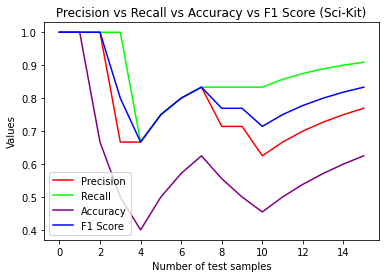

In [150]:
# Precision and Recall
def precisionAndRecall(predictedValues):
    actualValues = [1,1,0,0,1,1,1,1,0,0,0,1,1,1,1,1]
    truePositives = 0
    trueNegatives = 0
    falsePositives = 0
    falseNegatives = 0
    precision = []
    recall = []
    accuracy = []
    f1 = []

    for index in range(len(predictedValues)):
        if(predictedValues[index]==1 and actualValues[index]==1):
            truePositives += 1
            calculatedPrecision = 0
            calculatedRecall = 0
            if(truePositives+falseNegatives!=0):
                calculatedRecall = truePositives/(truePositives+falseNegatives)
                recall.append(calculatedRecall)
            if(truePositives+falsePositives!=0):
                calculatedPrecision = truePositives/(truePositives+falsePositives)
                precision.append(calculatedPrecision)
            if(truePositives+trueNegatives+falseNegatives+falsePositives!=0):
                accuracy.append(truePositives/(truePositives+trueNegatives+falseNegatives+falsePositives))
            if(calculatedRecall+calculatedPrecision!=0):
                f1.append((2*calculatedPrecision*calculatedRecall)/(calculatedRecall+calculatedPrecision))
            
        
        if(predictedValues[index]==1 and actualValues[index]==0):
            falsePositives += 1
            calculatedPrecision = 0
            calculatedRecall = 0
            if(truePositives+falseNegatives!=0):
                calculatedRecall = truePositives/(truePositives+falseNegatives)
                recall.append(calculatedRecall)
            if(truePositives+falsePositives!=0):
                calculatedPrecision = truePositives/(truePositives+falsePositives)
                precision.append(calculatedPrecision)
            if(truePositives+trueNegatives+falseNegatives+falsePositives!=0):
                accuracy.append(truePositives/(truePositives+trueNegatives+falseNegatives+falsePositives))
            if(calculatedRecall+calculatedPrecision!=0):
                f1.append((2*calculatedPrecision*calculatedRecall)/(calculatedRecall+calculatedPrecision))
        
        if(predictedValues[index]==0 and actualValues[index]==0):
            trueNegatives += 1
            calculatedPrecision = 0
            calculatedRecall = 0
            if(truePositives+falseNegatives!=0):
                calculatedRecall = truePositives/(truePositives+falseNegatives)
                recall.append(calculatedRecall)
            if(truePositives+falsePositives!=0):
                calculatedPrecision = truePositives/(truePositives+falsePositives)
                precision.append(calculatedPrecision)
            if(truePositives+trueNegatives+falseNegatives+falsePositives!=0):
                accuracy.append(truePositives/(truePositives+trueNegatives+falseNegatives+falsePositives))
            if(calculatedRecall+calculatedPrecision!=0):
                f1.append((2*calculatedPrecision*calculatedRecall)/(calculatedRecall+calculatedPrecision))

        if(predictedValues[index]==0 and actualValues[index]==1):
            falseNegatives += 1
            calculatedPrecision = 0
            calculatedRecall = 0
            if(truePositives+falseNegatives!=0):
                calculatedRecall = truePositives/(truePositives+falseNegatives)
                recall.append(calculatedRecall)
            if(truePositives+falsePositives!=0):
                calculatedPrecision = truePositives/(truePositives+falsePositives)
                precision.append(calculatedPrecision)
            if(truePositives+trueNegatives+falseNegatives+falsePositives!=0):
                accuracy.append(truePositives/(truePositives+trueNegatives+falseNegatives+falsePositives))
            if(calculatedRecall+calculatedPrecision!=0):
                f1.append((2*calculatedPrecision*calculatedRecall)/(calculatedRecall+calculatedPrecision))

    return precision,recall,accuracy,f1

precision, recall, accuracy, f1 = precisionAndRecall(dtree.predict(featuresTest))

plt.title("Precision vs Recall vs Accuracy vs F1 Score (Sci-Kit)")
plt.xlabel("Number of test samples")
plt.ylabel("Values")
plt.plot(precision,color = "red", label = "Precision")
plt.plot(recall,color = "lime", label = "Recall")
plt.plot(accuracy,color = "purple", label = "Accuracy")
plt.plot(f1,color = "blue", label = "F1 Score")

plt.legend()
plt.show()